# Вебинар 5. Ранжирование и Гибридные рекоммендательные системы

# 1. Ранжирование

### 1.1 BPR - Bayesian Personalized Ranking loss

$$loss = \sigma(p^{+} - p^{-})$$

1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p^{+}$, $p^{-}$ --> $p^{+} - p^{-}$
4. loss = $\sigma(p^{+} - p^{-})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

### 1.2 WARP = Weighted Approximate-Rank Pairwise loss
Неплохое [объяснение](https://medium.com/@gabrieltseng/intro-to-warp-loss-automatic-differentiation-and-pytorch-b6aa5083187a) на игрушечном примере

$$loss = ln(\frac{K-1}{N})*(p^- - p^+)$$

1. Сэмплируем случайную позитивную пару юзер-item, прогноз модели для этой пары $p^+$
2. Сюмплируем далее до тех пор, пока не найдем негативную пару, гду прогнозная вероятность вероятность $p^-$ > $p^+$
3. K - кол-во сэмплирований (зависит от качества модели!)
4. N - общее количество рекомендаций

**Note**  
loss зависит только от 2ух сэмплированных пар, эмбеддинги только для этих пар будут обновлены

# Case 1
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 4.5

loss(random_seed) = [(3-1) / 10 * (4.5 - 4.3)]

# Case 2 -  модель лучше в этом случае
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 0.5
p_neg_3 = -0.5
p_neg_4 = 2.1
p_neg_5 = 4.5

loss(random_seed) = [(6-1) / 10 * (4.5 - 4.3)]

### Зачем нужно ранжирование? Есть же классификация (предсказание 0 и 1)
- Ранжирование гораздо лучше выбирает топ-k товаров, особенно когда k велико
- Ранжирование позволяет напрямуб ранжировать 5 релевантных юзеру товаров (какой из 5 поставить выше?)

---

# 2. LightFM

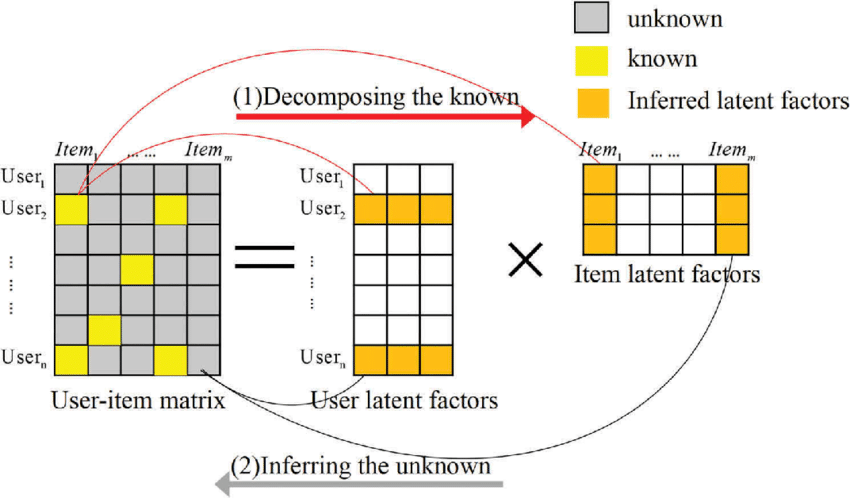

Формула эмбеддинга в ALS (матричной факторизации)

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

Формула в LightFM

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n + \alpha_1 * f_1 + ... + \alpha_k * f_k$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

### Зачем нужны гибридные системы?

*Холодный старт* - ситуация, в которой с товаром/юзером в матрице мало взаимодействий

Холодный страт для товаров - обычно введение нового товара (YouTube, Lamoda, hh.ru)  
Холодный старт для юзера - к нам пришел новый юзер  

Холодного юзера/товар можно описать фичами --> мы больше о нем знаем --> он уже не такой холодный

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from src.metrics import precision_at_k, recall_at_k
from utils import prefilter_items

C:\Users\aleksey\AppData\Local\Programs\Python\Python38\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [4]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [5]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [6]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [7]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

## 1. Filter items

In [8]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [9]:
n_items_before = data_train['item_id'].nunique()

data_train_filtered = prefilter_items(data_train, take_n_popular=5000, item_features=item_features)

n_items_after = data_train_filtered['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


# 2. Prepare data set

## 2.1 Prepare csr train matrix

In [10]:

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,25671,26081,26093,26190,26355,26426,26540,26601,26636,26691,...,17328742,17329473,17329749,17330255,17330511,17381856,17382205,17383227,17827644,17829232
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 Prepare CSR test matrix

In [11]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float) # необходимый тип матрицы для implicit
test_sparse_user_item = csr_matrix(test_user_item_matrix).tocsr()

In [12]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [13]:
user_features

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


In [14]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)
user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
user_feat.shape

(2499, 7)

In [16]:
item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

item_feat.head(2)

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
item_id,,,,,,
25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [17]:
item_feat.shape

(86865, 6)

## Encoding features

In [18]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [19]:
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Init model

In [20]:
model = LightFM(no_components=30,
#                 loss='bpr',
                loss='warp',
                learning_rate=0.08, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=43)

## Train

In [21]:
%%time
model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=10, 
          num_threads=8,
          verbose=True) 

Epoch: 100%|██████████| 8/8 [03:53<00:00, 29.17s/it]Wall time: 4min 16s



In [22]:
# user_emb = model.get_user_representations(features=csr_matrix(user_feat_lightfm.values).tocsr())

In [23]:
# user_emb[0]  # biases

In [24]:
# user_emb[0].shape

In [25]:
# user_emb[1]  # embeddings

In [26]:
# user_emb[1].shape

In [27]:
# item_emb = model.get_item_representations(features=csr_matrix(item_feat_lightfm.values).tocsr())

In [28]:
# item_emb[0].shape

In [29]:
# item_emb[1].shape

In [32]:
%%time
train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 num_threads=8,
                                 k=5).mean()

train_precision

Wall time: 4min 5s


0.18311326

In [33]:
%%time
test_precision = precision_at_k(model, test_sparse_user_item,
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 num_threads=8,
                                 k=5).mean()

test_precision

Wall time: 31.4 s


0.002155806

LigthFM -> https://arxiv.org/pdf/1507.08439.pdf

predictions - некоторые числа. 

## 1) Посчитать метрики на тестовом датасете

я посчитал  precision_at_k на одной выборке поменяв всего лишь значение random_state  с 42 до 43. погрешность сосставила 50%. что бы посчитать реальные значение потребуется всего лишь 2500 кросс валидации что бы уменьшить погрешность до ~ 1%. Но учитывая что модель считается примерно 5 - 20+ минут мы вряд ли можем себе такое позволить. Но задание есть задание.

Возьмем несколько значений бля сетки параметров.

In [52]:
losses = ['warp']
learning_rates = [0.1, 0.05, 0.001]
number_of_components = [15, 30, 60]

In [53]:
results_train = pd.DataFrame(np.zeros((3,3)), columns=learning_rates, index=number_of_components)

In [54]:
results_test = pd.DataFrame(np.zeros((3,3)), columns=learning_rates, index=number_of_components)

In [55]:
results_test

,0.100,0.050,0.001
15,0.0,0.0,0.0
30,0.0,0.0,0.0
60,0.0,0.0,0.0


Тут уже 9 пересечений каждая считается по 10+ минут. Эпохи добавлять не будем. так как ноутбук умрет. Вначале посчитаем на warp. Потом лучший резльтат сравним с bpr. По сути тут надо понимать что параметрами должны быть :
- no_components
- loss
- learning_rate
- item_alpha
- user_alpha
- epochs

Но провести такую кросвалидацию просто невозможно на домашнем компьютере.

In [56]:
from tqdm.notebook import tqdm

In [57]:
%%time
results
for learning_rate in tqdm(learning_rates):
    for number_of_component in tqdm(number_of_components):

        model = LightFM(no_components=number_of_component,
                loss='warp',
                learning_rate=learning_rate, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=43)

        model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=10, 
          num_threads=8,
          verbose=False)

        train_precision = precision_at_k(model, sparse_user_item, 
                                        user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                        item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                        num_threads=8,
                                        k=5).mean()

        results_train.at[number_of_component,learning_rate] = train_precision

        test_precision = precision_at_k(model, test_sparse_user_item,
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 num_threads=8,
                                 k=5).mean()

        results_test.at[number_of_component, learning_rate] = test_precision



Wall time: 1h 28min 32s


In [58]:
results_test

,0.100,0.050,0.001
15,0.005390,0.002254,0.000392
30,0.002548,0.002254,0.000588
60,0.002450,0.003234,0.000490


In [60]:
results_train

,0.100,0.050,0.001
15,0.203762,0.051701,0.023449
30,0.168788,0.099560,0.023289
60,0.102121,0.051701,0.023049


Похоже нужно уменьшать количество компонент. что весьма странно. и увеличивать ленинг рейт. Опять же учитывая дисперсию. Не совсем понимаю какие выводы мы можем сделать. Можно написать функцию для прересчета, это крайне просто, но пересчитывать полтора часа не хочется.

In [64]:
model = LightFM(no_components=15,
                loss='bpr',
                learning_rate=0.1, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=43)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
    sample_weight=coo_matrix(user_item_matrix),
    user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
    item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
    epochs=10, 
    num_threads=8,
    verbose=False)

train_precision = precision_at_k(model, sparse_user_item, 
                                user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                num_threads=8,
                                k=5).mean()

train_precision

0.0

In [65]:
test_precision = precision_at_k(model, test_sparse_user_item,
                                user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                num_threads=8,
                                k=5).mean()

test_precision

0.0012738853

In [66]:
model = LightFM(no_components=15,
                loss='bpr',
                learning_rate=0.01, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=43)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
    sample_weight=coo_matrix(user_item_matrix),
    user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
    item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
    epochs=10, 
    num_threads=8,
    verbose=False)

train_precision = precision_at_k(model, sparse_user_item, 
                                user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                num_threads=8,
                                k=5).mean()

train_precision

0.0

In [67]:
test_precision = precision_at_k(model, test_sparse_user_item,
                                user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                num_threads=8,
                                k=5).mean()

test_precision

0.0006859383

Не понимаю почему такие результаты, вроде в документации ничего про это нету, кроме того что brp обучается быстрее. Так что странные результаты. В итоге я не очень понимаю как относиться к тем метрикам которые мы посчитали. Еще я посчитал roc_auc для теста и для трейна. Для трейна он был в районе 0.78, а для теста 0.5-0.53, не понимаю значит ли это что-то, или просто roc_auc нерелевантен тут.